# Neural tangent kernel on a regression task

This tutorial follows the `laplace-torch` regression tutorial. It is a great start to visually understand the Neural Tangent Kernel. 

In [138]:
import jax
import jax.numpy as jnp
import optax
from flax import nnx
from helper import get_sinusoid_example
from plotting import plot_regression_with_uncertainty

n_epochs = 1000
key = jax.random.key(0)

# Sample toy data example
X_train, y_train, train_loader, X_test = get_sinusoid_example(sigma_noise=0.3, batch_size=20)

## Training a MAP

In this tutorial we use `flax.nnx` for training a neural network. Other libraries should likely work out of the box, if you can bring them in the correct form of `model_fn` and `params`.

In [139]:
# create and train MAP model
class Model(nnx.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, rngs):
        self.linear1 = nnx.Linear(in_channels, hidden_channels, rngs=rngs)
        self.tanh = nnx.tanh
        self.linear2 = nnx.Linear(hidden_channels, out_channels, rngs=rngs)

    def __call__(self, x):
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        return x


# Initialize model
model = Model(in_channels=1, hidden_channels=50, out_channels=1, rngs=nnx.Rngs(0))


# Set loss function
def criterion(x, y):
    return jnp.mean((x - y) ** 2)


# Create optimizer
optimizer = nnx.Optimizer(model, optax.adamw(1e-3))  # reference sharing


@nnx.jit
def train_step(model, optimizer, x, y):
  def loss_fn(model):
    y_pred = model(x)  # call methods directly
    return criterion(y, y_pred)

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)  # inplace updates

  return loss

In [140]:
for epoch in range(500):
    for x_train, y_train in train_loader:
        loss = train_step(model, optimizer, x_train, y_train)
        print("loss: ", loss, end="\r")

## Setup Full Laplace

In [141]:
from laplax.curv import create_ggn_mv
from laplax.util.util import input_target_split

# Create GGN
graph_def, params = nnx.split(model)


def model_fn(input, params):
    return nnx.call((graph_def, params))(input)[0]


train_batch = input_target_split(next(iter(train_loader)))
ggn_mv = create_ggn_mv(model_fn, params, train_batch, loss_fn="mse")

In [142]:
from laplax.curv.cov import create_posterior_function

# Create Posterior
get_posterior = create_posterior_function(
    "full",
    mv=ggn_mv,
    layout=params,
    key=jax.random.key(20),
)

## Setup Neural Tangent Kernel

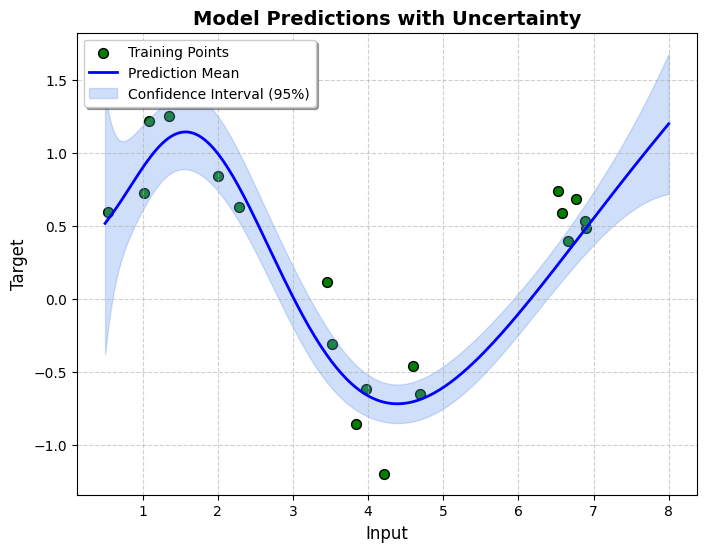

In [143]:
from laplax.eval.push_forward import set_ntk

prior_arguments = {"prior_prec": 1.0}

ntk = set_ntk(
    model_fn=model_fn,
    mean=params,
    posterior=get_posterior,
    prior_arguments=prior_arguments,
    dense=True,     # If dense = False, then a kernel-vector product is returned.
    output_layout=1
)

X_grid = jnp.linspace(0.5, 8, 200).reshape(200, 1)
Y_pred = model_fn(X_grid, params)[:, 0]

Y_var = jax.vmap(lambda x: ntk(x, x))(X_grid)[:, 0, 0]

plot_regression_with_uncertainty(
    train_input=train_batch["input"],
    train_target=train_batch["target"],
    X_grid=X_grid, 
    Y_pred=Y_pred, 
    Y_var=Y_var,
)

## Setup Low Rank Laplace

In [144]:
from laplax.curv.cov import create_posterior_function

# Create Posterior
get_posterior = create_posterior_function(
    "low_rank",
    mv=ggn_mv,
    layout=params,
    key=jax.random.key(20),
    maxiter=50,
    mv_jittable=True
)

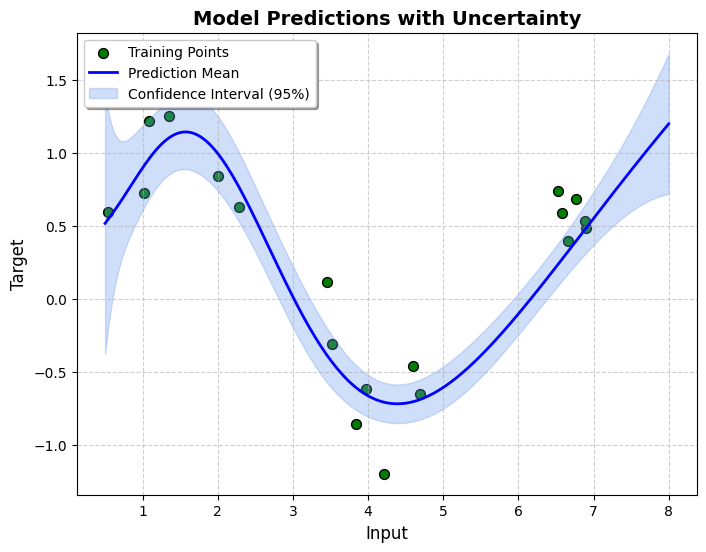

In [145]:
from laplax.eval.push_forward import set_ntk

prior_arguments = {"prior_prec": 1.0}

ntk = set_ntk(
    model_fn=model_fn,
    mean=params,
    posterior=get_posterior,
    prior_arguments=prior_arguments,
    dense=True,     # If dense = False, then a kernel-vector product is returned.
    output_layout=1
)

X_grid = jnp.linspace(0.5, 8, 200).reshape(200, 1)
Y_pred = model_fn(X_grid, params)[:, 0]

Y_var = jax.vmap(lambda x: ntk(x, x))(X_grid)[:, 0, 0]

plot_regression_with_uncertainty(
    train_input=train_batch["input"],
    train_target=train_batch["target"],
    X_grid=X_grid,
    Y_pred=Y_pred,
    Y_var=Y_var,
)